# Cosmic Joiner
In this notebook I demonstrate an alternate method to join disperate parts of cosmic trails into one. Since the spectroscopic fibers are typically illuminated beyond the background level of the images, any cosmics that strike the CCD will typically be detected (at least with the algorithm currently in use) with gaps where the fibers are. This can be seen in the first plot of the cosmic mask. 

In an attempt to join these cosmics into single lines, this script first groups each pixel but what cosmic it is in. This is done by dilating the cosmics so that they cover a larger area and are easier to label. Once the cosmics are labeled, a probabilistic Hough transform is run to try determine all the straight lines. Lines are grouped according to which labeled region 

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage # Need this for the labeling

from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize # For displaying the preproc images

from skimage.transform import probabilistic_hough_line
from skimage.morphology import binary_dilation

import os
import time

## Display the Image
First displays the image so we can see what it looks like. Cosmics should be relatively easy to pick out by eye so this provides a baseline for us to compare to later.

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


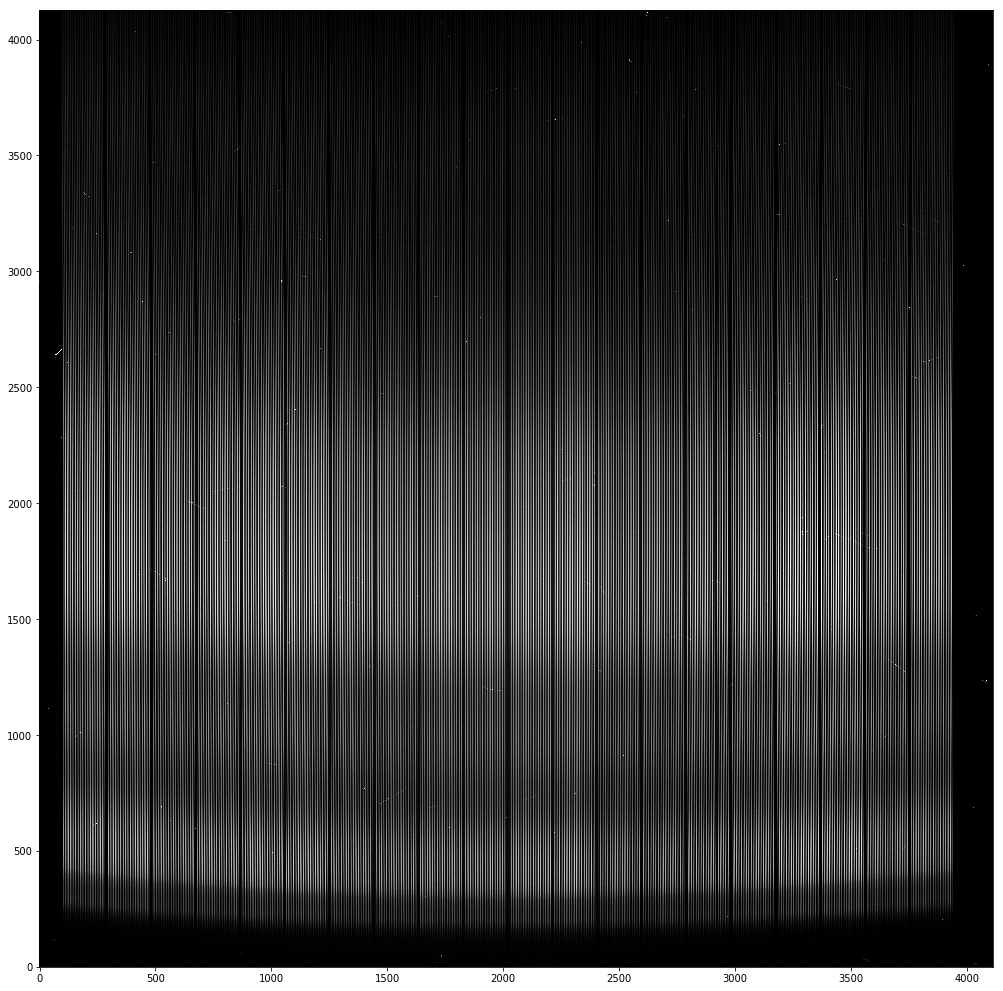

In [7]:
hdus = fits.open("/global/project/projectdirs/desi/spectro/redux/daily/preproc/20191208/00031136/preproc-z3-00031136.fits")
img = hdus["IMAGE"].data
mask = hdus["MASK"].data

# Normalization for the image to display nicer (ish)
zscale = ZScaleInterval()
norm = ImageNormalize(img, zscale)

fig, ax = plt.subplots(1,1, figsize=(14,14), tight_layout=True)
ax.imshow(img, cmap='gray', origin="lower", interpolation=None, norm=norm)

## Grouping Test
The following few cells are designed to test the method itself. After the tests I've condensed them into simple functions that can be run or extrapolated.

This downsample code is from the DESI Nightwatch display code

In [8]:
def downsample_image(image, n):
    '''Downsample input image n x n
    Returns resampled images with shape = image.shape//n
    '''
    ny, nx = image.shape
    ny = (ny//n) * n
    nx = (nx//n) * n
    result = image[0:ny, 0:nx].reshape(ny//n,n,nx//n,n).mean(axis=-1).mean(axis=-2)
    return result

We then downsample and display the mask. We downsample to increase the runspeed of the script for testing, but in theory it should be scalable. 

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


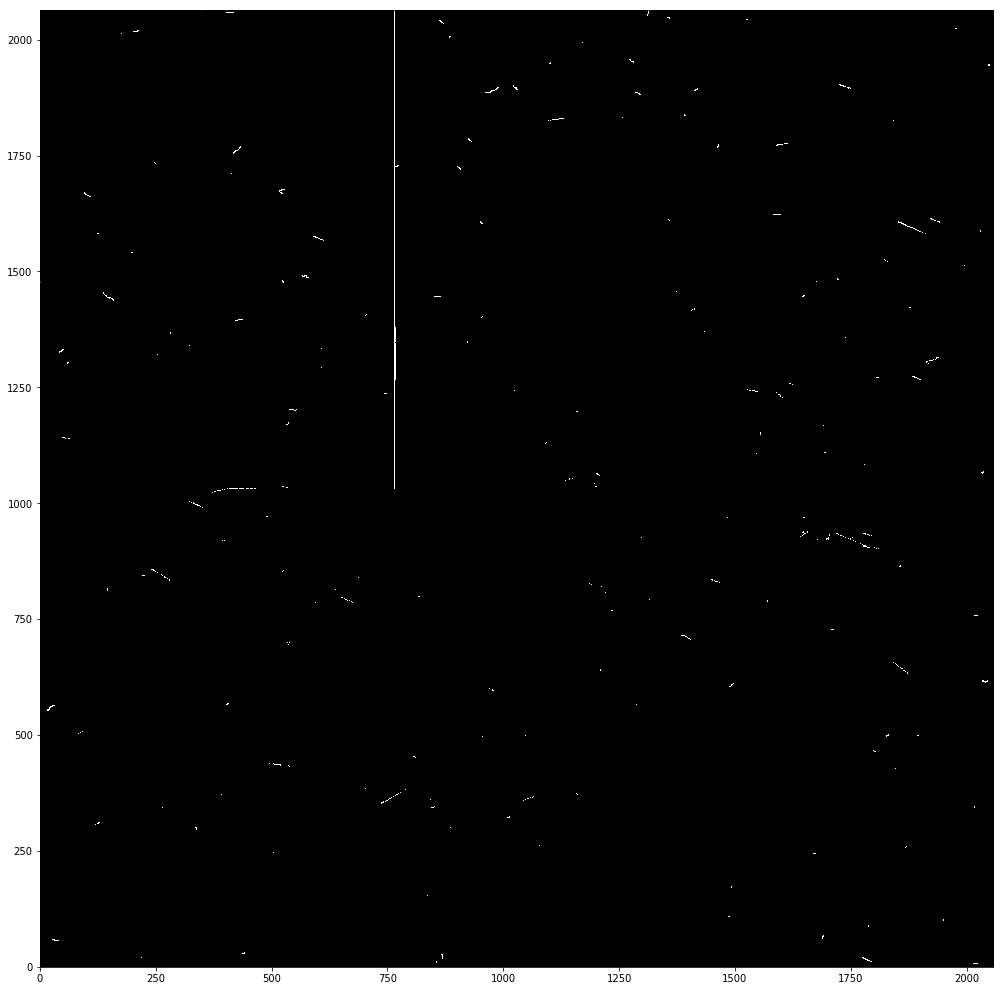

In [17]:
m = downsample_image(mask, 2)
fig, ax = plt.subplots(1,1, figsize=(14,14), tight_layout=True)
ax.imshow(m, cmap="gray", vmin=0, vmax=1, origin="lower")

Dilates the mask with a 10x10 kernel and then labels each region. This should expand disconnected segments to join without merging two cosmics unless the cosmics cross or come within 10 pixels of each other, which in general is unlikely due to the spectroscopic fibers. The fibers themselves are what's causing the ~< 10 pixel gaps in single cosmics, so any other cosmic that comes that close can only do so in 1 dimension (the y dimension) as cosmics that close in the x dimension will get masked by the fibers. The displays are the dilated mask on top, and then the dilated mask with the color of each group corresponding to its group number.

178


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


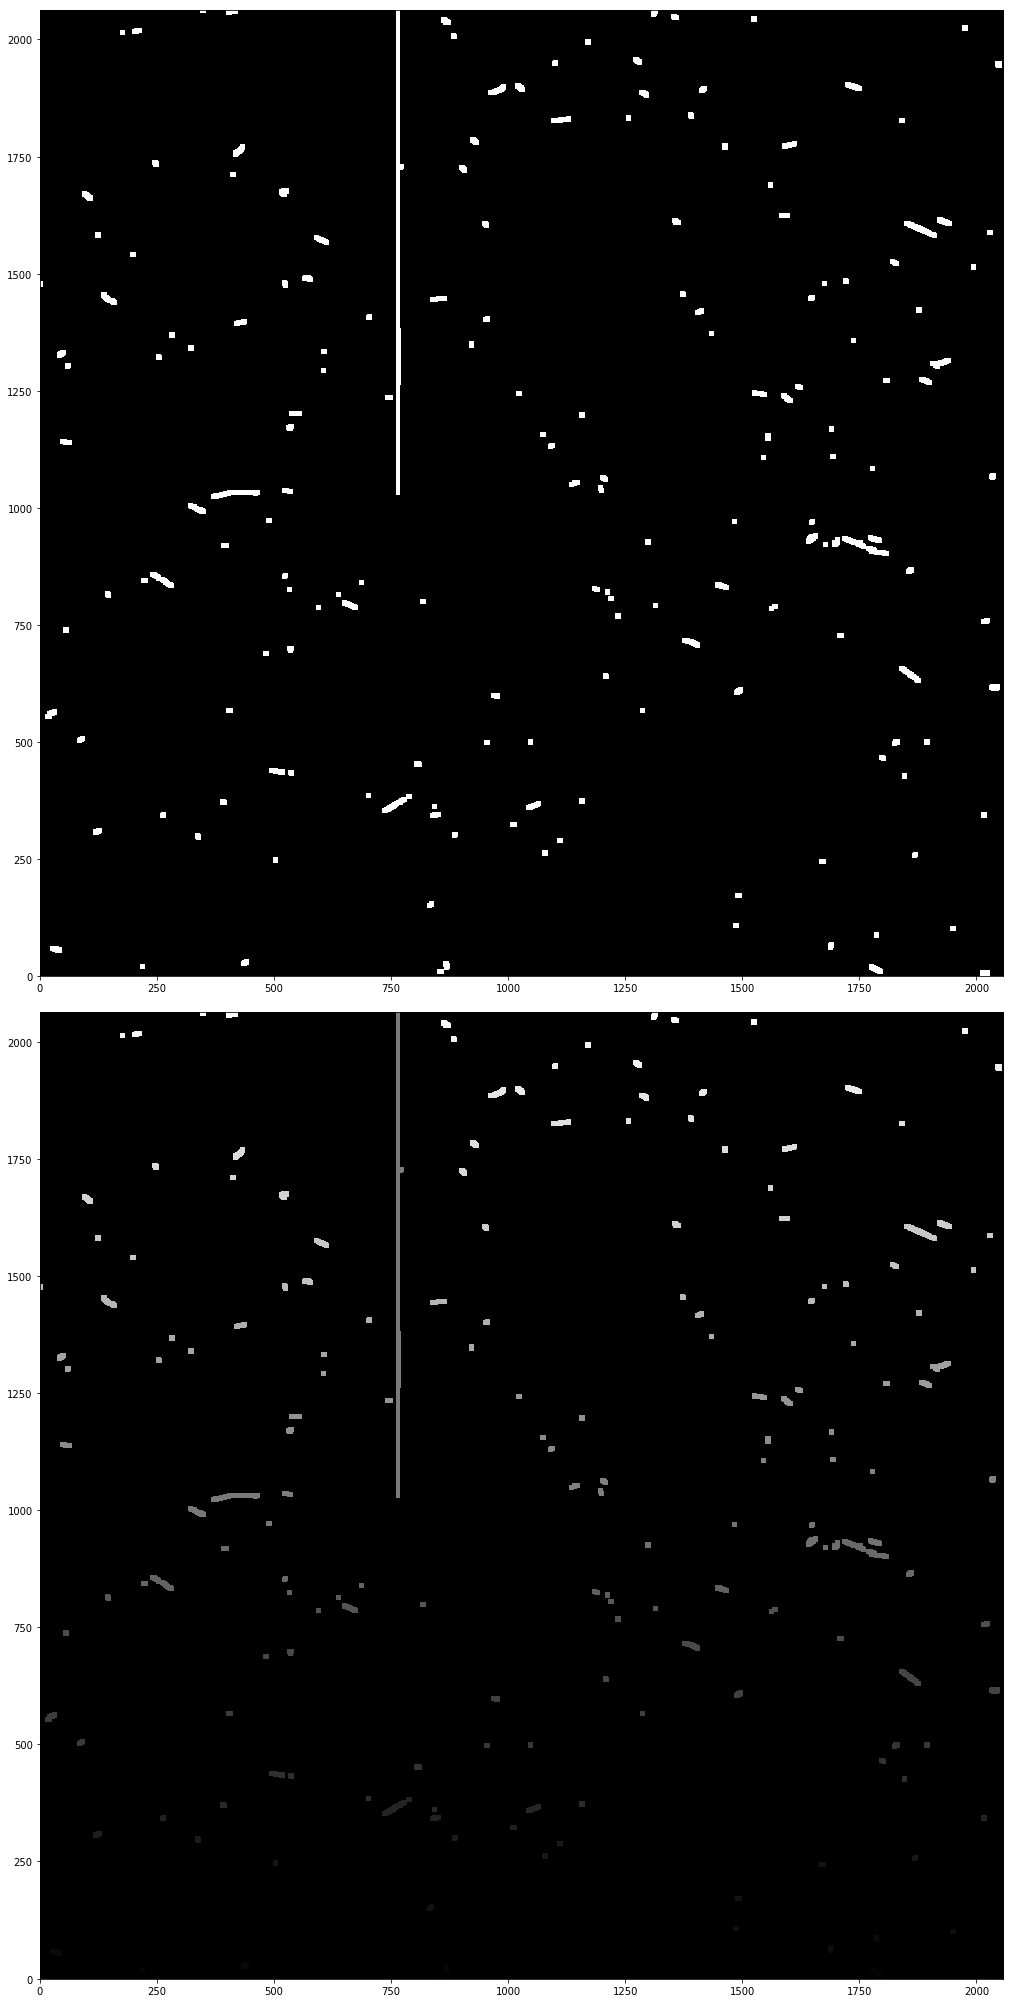

In [18]:
m_binary = m > 0
m_dilate = binary_dilation(m_binary, np.ones((10, 10)))

fig, ax = plt.subplots(2, 1, figsize=(14,28), tight_layout=True)

ax[0].imshow(m_dilate, cmap="gray", vmin=0, vmax=1, origin="lower")

m_labels, num_labels = ndimage.label(m_dilate)
print(num_labels)
ax[1].imshow(m_labels, cmap="gray", origin="lower")

Here I run a probabilistic Hough transform in order to generate the straight lines. Typically it finds many more lines than there are cosmics because sometimes a single cosmic will lead to multiple lines found.

In [13]:
lines = probabilistic_hough_line(m_binary, threshold=10, line_length=5, line_gap=6, seed=1)
print(len(lines))
print(lines[0])

319
((764, 2063), (764, 1032))


## Functions

The functions below are the two main functions used to reduce the number of found lines down to a manageable number. cosmic_lines will find the lines in a mask, and then automatically reduce them down. First it takes the mask and generates groupings for each cosmic. It then runs the probabilistic hough transform. categorize will take a set of lines and group them into categories using the categories that it just generated. Finally it will take a group of lines and reduce it further to three points: the leftmost x coordinate point, the rightmost x coordinate point and the median x coordinate point. 

In [14]:
def categorize(lines, mask):
    
    # Empty list of lists with number of label categories
    groups = [[] for i in range(np.max(mask))]

    for line in lines:
        p0, p1 = line
        
        # Coords are flipped to the points in the line
        cat = mask[p1[1], p1[0]]
        
        try:
            groups[cat].append(line)
        except:
            print(np.max(mask))
            print(len(groups))
            print(cat)
            print()
    
    return groups

In [15]:
def cosmic_lines(mask):
    # Downsample the image by 2 for speed
    m2 = downsample_image(mask, 2) > 0
    
    # Dilation to expand disconnected cosmics
    k = np.ones((10, 10))
    m_dilate = binary_dilation(m2, k)
    
    # Label each discrete 
    m_labels, num_labels = ndimage.label(m_dilate)
    print("Number of labeled regions:", num_labels)

    # Perform the hough transform to find straight lines
    lines = probabilistic_hough_line(m2, threshold=10, line_length=5, line_gap=6, seed=1)
    print("Number of lines found:", len(lines))
    
    # Reduces the number of lines by categorizing.
    # Checks end points of lines, sees which category they're in and returns them.
    groups = categorize(lines, m_labels)
    
    # Gets all the start/end points of the lines contained in each group
    group_points = [[] for i in range(len(groups))]
    for i, g in enumerate(groups):
        for line in g:
            p0, p1 = line
            group_points[i].append(np.asarray(p0))
            group_points[i].append(np.asarray(p1))

    # Condenses each group down to three key points: the leftmost, rightmost and median x positions.
    # Could easily justify using upper, lower and median y positions as well.
    new_groups = []
    for i, g in enumerate(group_points):
        t = sorted(np.asarray(g), key = lambda x: x[0])
        if len(t) > 0:
            new_groups.append([t[0], np.median(t, axis=0), t[-1]])

    print("Final number of lines:", len(new_groups))
    return new_groups
    

finally using the cosmic_lines method we test everything together, and plot the cosmic lines in white so that we can see a "simulation" of what the complete cosmic mask should look like. 

Number of labeled regions: 178
Number of lines found: 319
Final number of lines: 85
Time: 0.7499372959136963


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


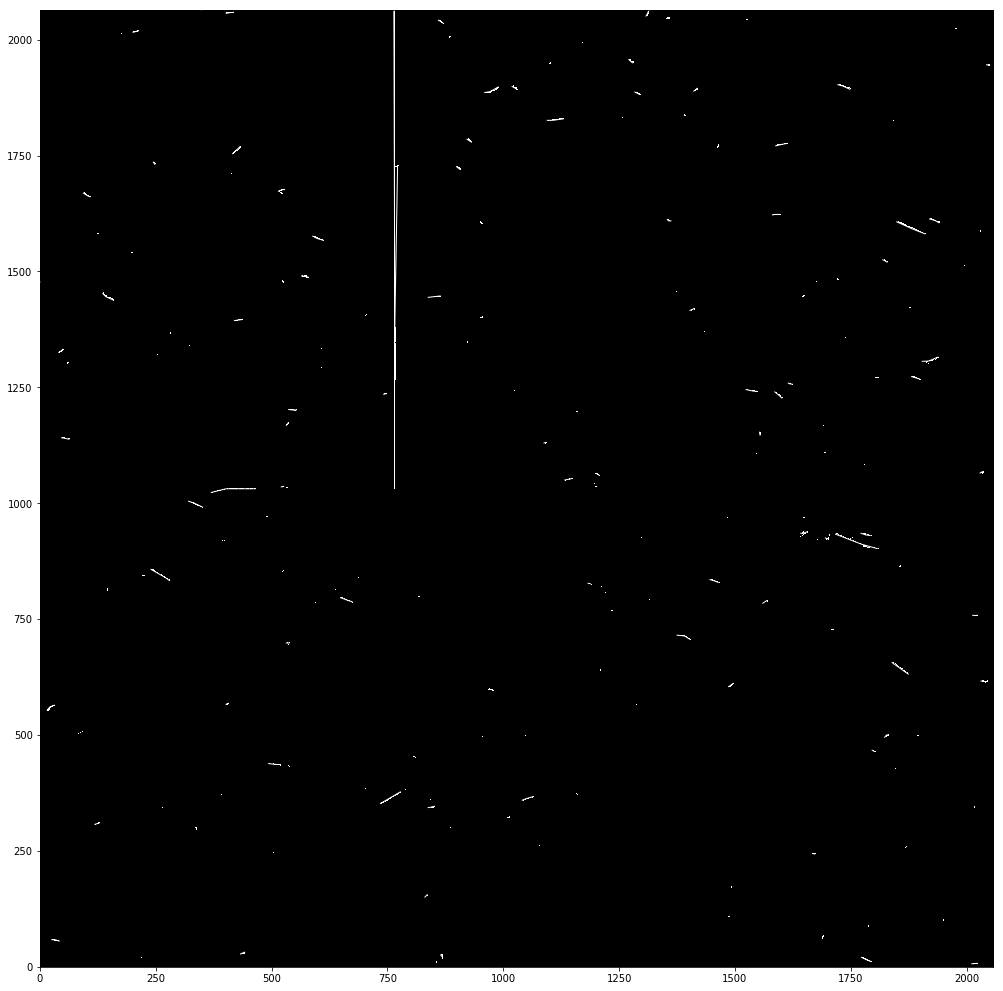

In [21]:
hdus = fits.open("/global/project/projectdirs/desi/spectro/redux/daily/preproc/20191208/00031136/preproc-z3-00031136.fits")
img = hdus["IMAGE"].data
mask = hdus["MASK"].data

m = downsample_image(mask, 2)
fig, ax = plt.subplots(1, 1, figsize=(14,14), tight_layout=True)

ax.imshow(m, cmap="gray", vmin=0, vmax=1, origin="lower")

t1 = time.time()
g1 = cosmic_lines(mask)
t2 = time.time()

print("Time:", t2-t1)

for line in g1:
    colors = ["r", "b", "y", "g", "m", "c", "w"]
    colors = plt.cm.get_cmap("hsv", len(g1))
    c = np.random.randint(0, len(g1))
    p0, p1, p2 = line
    ax.plot((p0[0], p1[0], p2[0]), (p0[1], p1[1], p2[1]), linewidth=1, color="white")
    

The following is a much noiser image with many more cosmics. ON the left is the original cosmic mask, and on the right is the one with the attempted connected cosmics. The method slightly fails in the upper right, where a cosmic intersects another cosmic creating almost three distinct intersecting lines. 

Number of labeled regions: 701
Number of lines found: 2056
Final number of lines: 390
Time: 0.7868506908416748


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


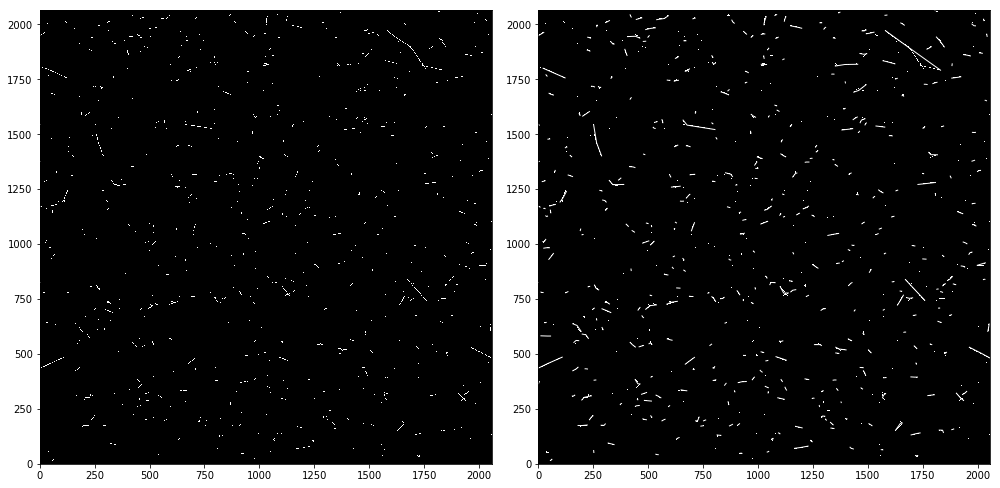

In [22]:

hdus = fits.open("/project/projectdirs/desi/spectro/redux/daily/preproc/20191216/00033090/preproc-r4-00033090.fits")
img = hdus["IMAGE"].data
mask = hdus["MASK"].data

fig, ax = plt.subplots(1, 2, figsize=(14,14), tight_layout=True)

m = downsample_image(mask, 2)
ax[0].imshow(m, cmap="gray", vmin=0, vmax=1, origin="lower")
ax[1].imshow(m, cmap="gray", vmin=0, vmax=1, origin="lower")

t1 = time.time()
g1 = cosmic_lines(mask)
t2 = time.time()

print("Time:", t2-t1)

for line in g1:
    colors = ["r", "b", "y", "g", "m", "c", "w"]
    colors = plt.cm.get_cmap("hsv", len(g1))
    c = np.random.randint(0, len(g1))
    p0, p1, p2 = line
    ax[1].plot((p0[0], p1[0], p2[0]), (p0[1], p1[1], p2[1]), linewidth = 1, color="white")

plt.savefig("r4-00033090.png")

## Extracting the Cosmic Mask
Once the mask is expanded, the followup challenge is extracting the new mask from the plot figure. The following reuses some code I wrote a few years ago for David in order to extract an image where I had drawn a circular contour on an all-sky image. 

(2064, 2057)
Number of labeled regions: 178
Number of lines found: 319
Final number of lines: 85
Time: 1.3434782028198242


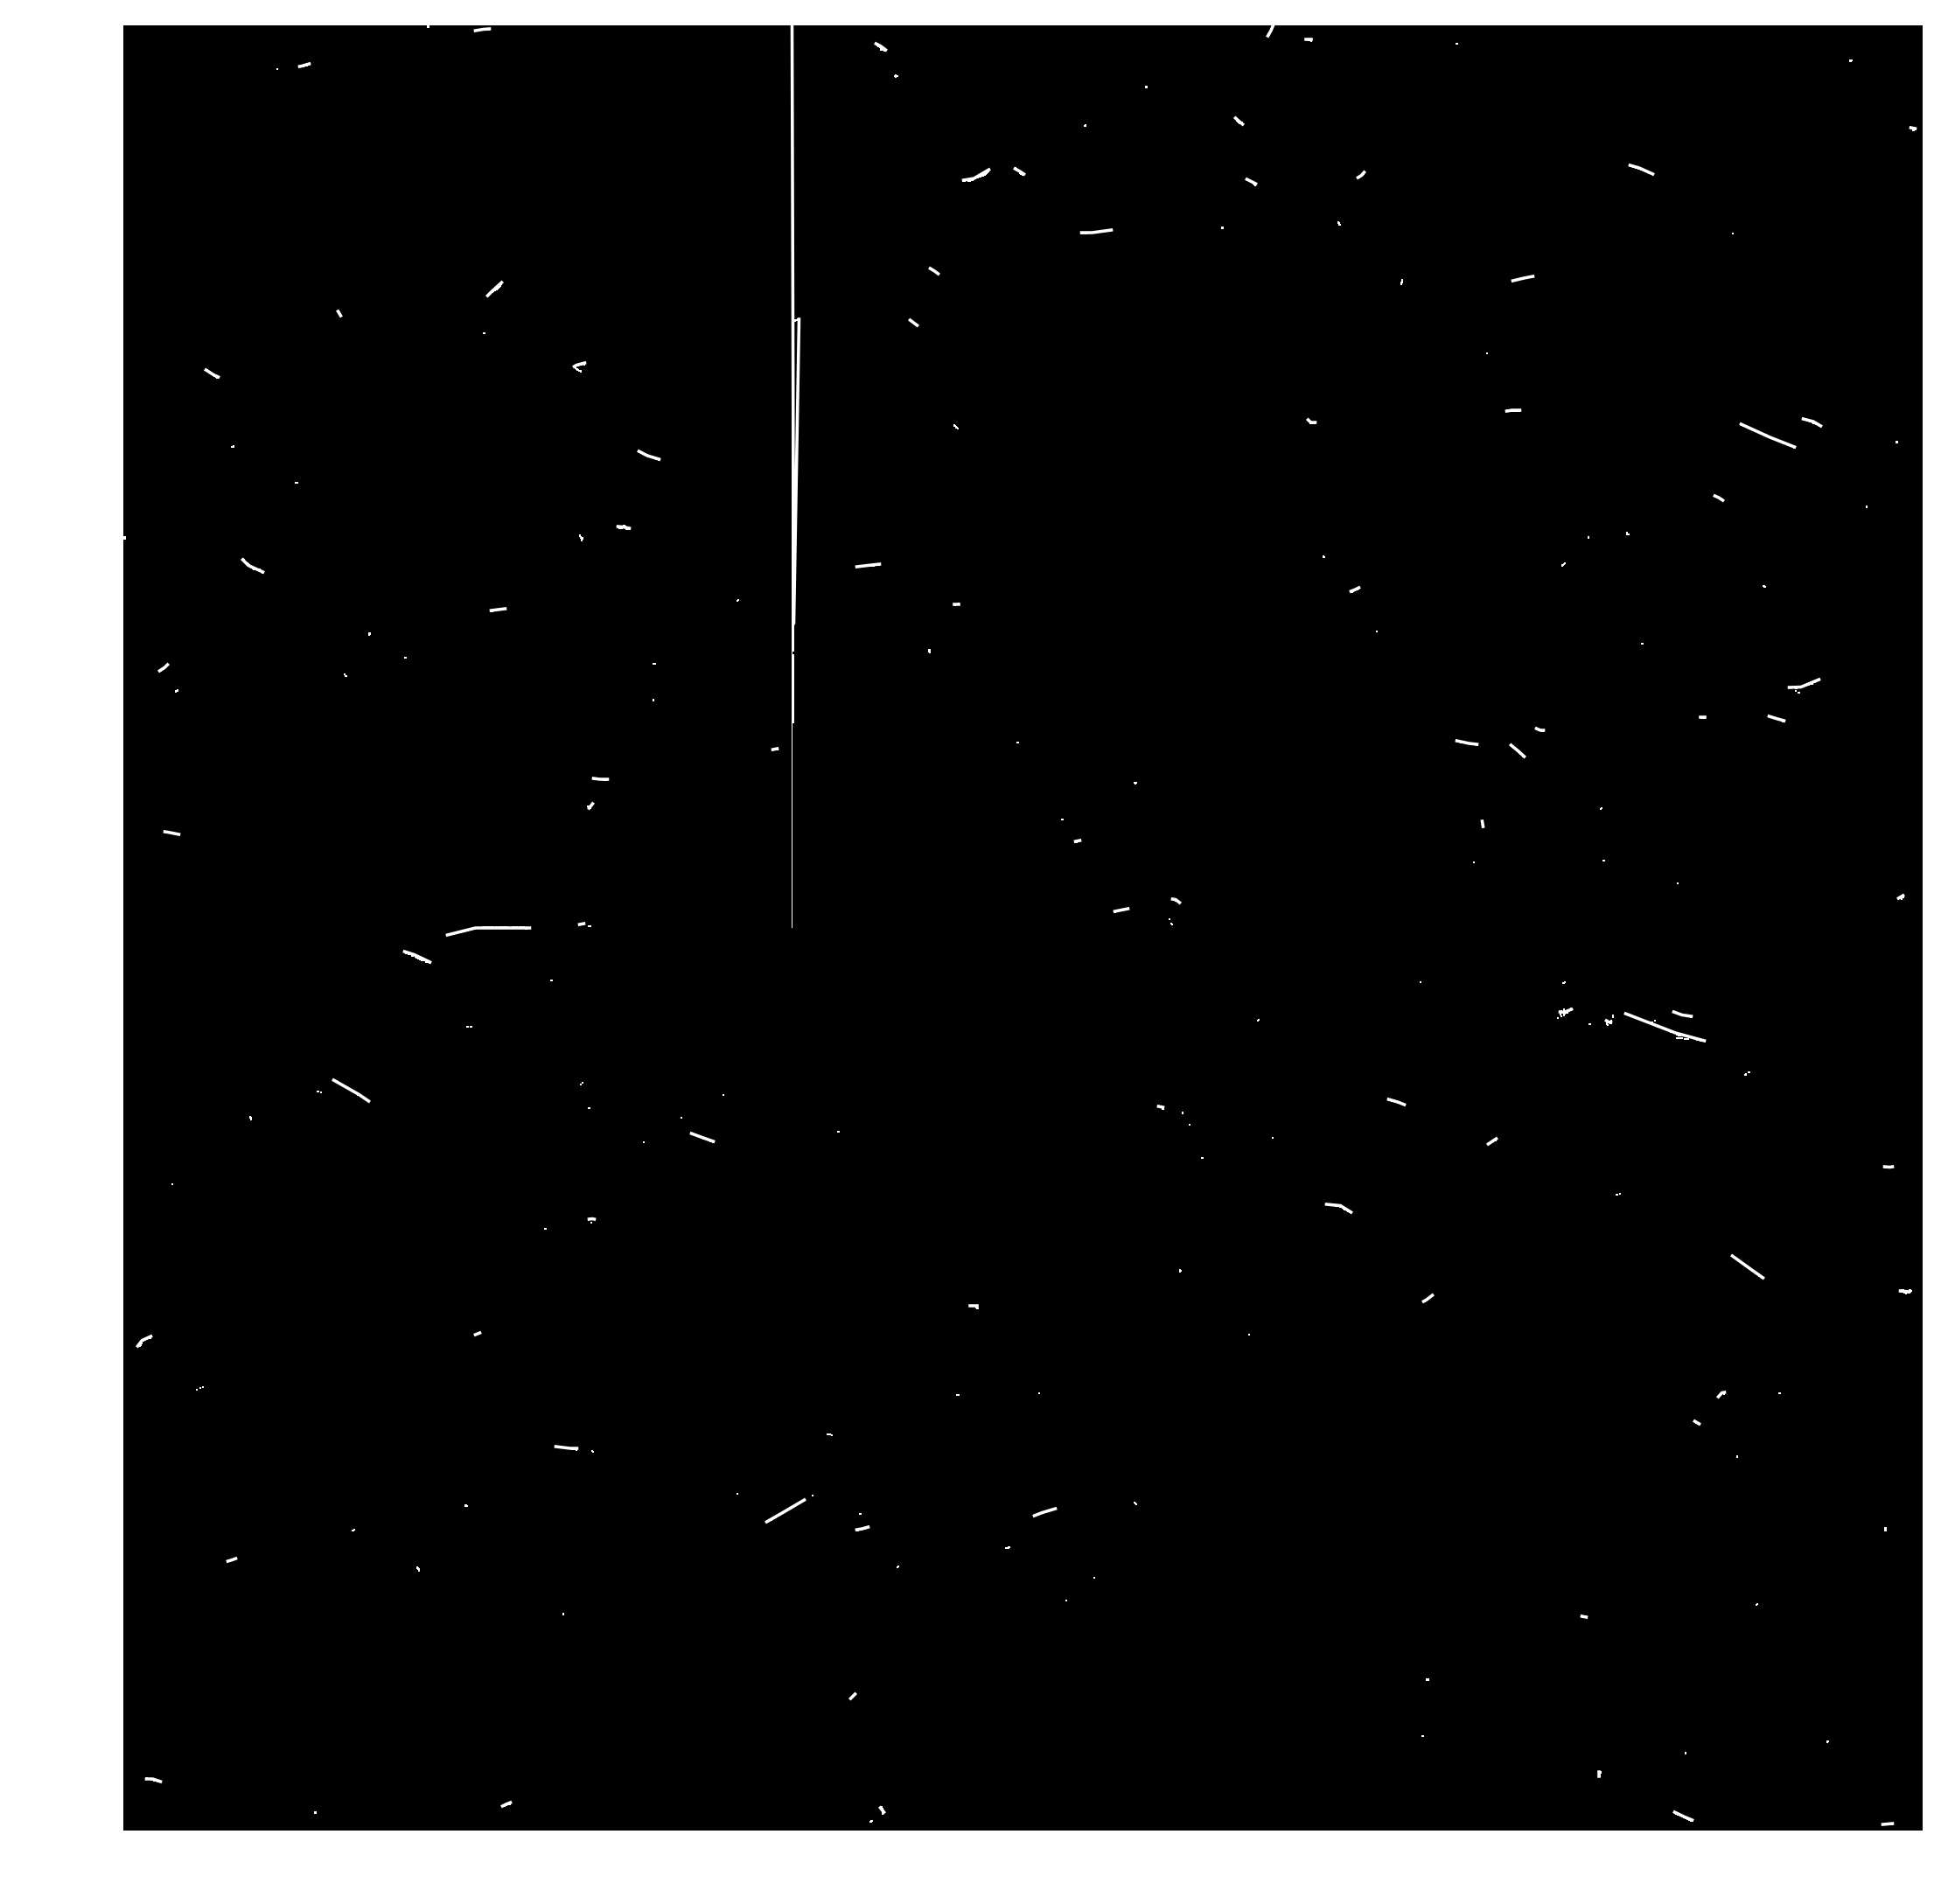

In [23]:

# hdus = fits.open("/project/projectdirs/desi/spectro/redux/daily/preproc/20191216/00033090/preproc-r4-00033090.fits")
hdus = fits.open("/global/project/projectdirs/desi/spectro/redux/daily/preproc/20191208/00031136/preproc-z3-00031136.fits")
img = hdus["IMAGE"].data
mask = hdus["MASK"].data

m = downsample_image(mask, 2)

print(m.shape)

# This code is slightly different than before because we need to carefully control the figure size in order
# to get the masking image to come out exactly the same size as before. Hence the figure size needs to be
# dependent on the figure size. 
dpi = 256
fig = plt.figure()
fig.set_size_inches(m.shape[1] / dpi, m.shape[0] / dpi)
fig.set_dpi(dpi)
ax = plt.Axes(fig, [0., 0., 1., 1.])

# Turn off the actual visual axes for visual niceness.
# Then add axes to figure
ax.set_axis_off()
fig.add_axes(ax)

ax.imshow(m, cmap="gray", vmin=0, vmax=1, origin="lower")

t1 = time.time()
g1 = cosmic_lines(mask)

for line in g1:
    colors = ["r", "b", "y", "g", "m", "c", "w"]
    colors = plt.cm.get_cmap("hsv", len(g1))
    c = np.random.randint(0, len(g1))
    p0, p1, p2 = line
    ax.plot((p0[0], p1[0], p2[0]), (p0[1], p1[1], p2[1]), linewidth = 1, color="white")

# You can only extract from the figure canvas in RGB, which is then shoved into a single array of
# length x*y*3. Hence why it also needs to be reshaped. It's a bit daft in my opinion. But it works.
fig.canvas.draw()
data = np.fromstring(fig.canvas.tostring_rgb(), dtype="uint8").reshape((m.shape[0], m.shape[1], -1))
data = np.dot(data[...,:3], [0.299, 0.587, 0.114]) > 0 # Converts to greyscale then to binary.

t2 = time.time() 
print("Time:", t2-t1) # Want to time how long it takes with extracting it from the matplotlib figure as well.
# plt.savefig("r4-00033090.png")

Here we just plot the extracted array to ensure that we got the same thing as what was plotted before. 

(2064, 2057)


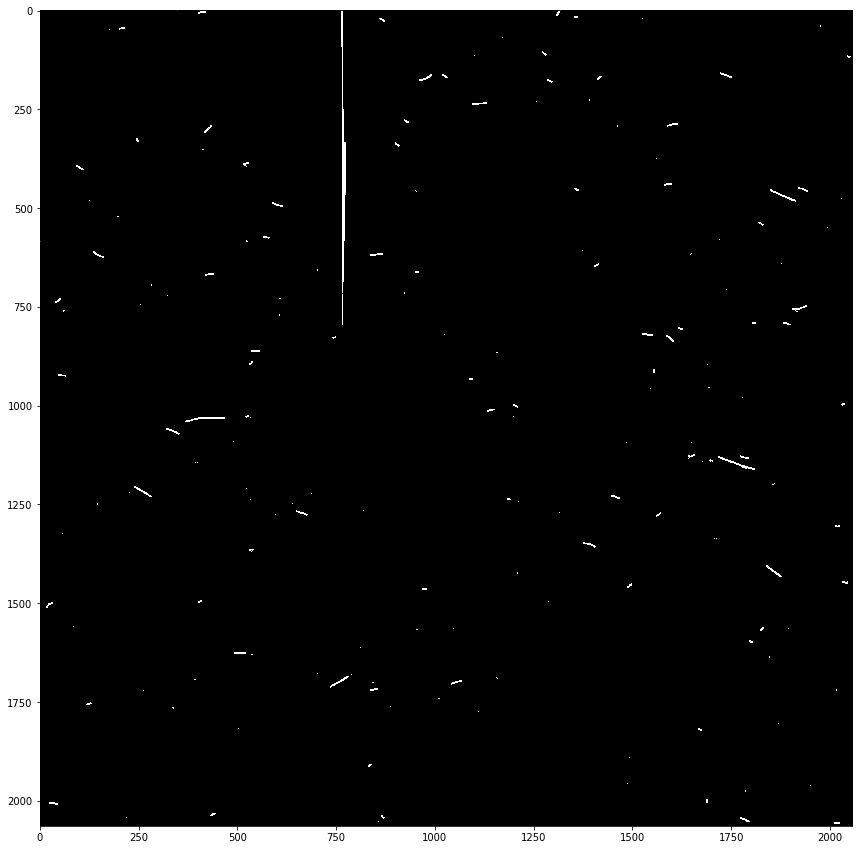

In [26]:
print(data.shape)
fig, ax = plt.subplots(figsize = (15,15))
plt.imshow(data, cmap="gray")

This old grouping method grouped lines by the distance to each other. I've left it here for posterity.

In [25]:
import copy
def reduce3(lines):
    l2 = copy.copy(lines)

    
    groups = [[]]
    slopes = []
    
    cur_slope = 0
    slopes.append(cur_slope)
    cur_line = lines[0]
    
    i = 0 
    while i < len(l2):
        # Ignores vertical lines
        if l2[i][0][0] == l2[i][1][0]:
            i += 1
            continue
            
        groups[-1].append(l2[i])
            
#         cur_slope = (l2[i][0][0] - l2[i][1][0]) / (l2[i][0][1] - l2[i][1][1])
        
        temp = np.asarray(l2[i])
        c1 = np.mean(temp, axis = 0)
            
        j = i+1
        
        while j < len(l2):
            p0, p1 = l2[j]

            # Length of the line
    #         length = np.hypot(p1[0] - p0[0], p1[1] - p0[1])

#             # Divide by zero errors are the bane of my existence
#             if p1[1] == p0[1]:
#                 j += 1
#                 continue
#             else:
#                 slope = (p1[0] - p0[0]) / (p1[1] - p0[1])

            temp = np.asarray(l2[j])
            c2 = np.mean(temp, axis = 0)
        
            # Difference in start points
            d1 = np.hypot(p0[0] - l2[i][0][0], p0[1] - l2[i][0][1])

            # Difference in end points
            d2 = np.hypot(p1[0] - l2[i][1][0], p1[1] - l2[i][1][1])
            
            # Difference in end points
            d3 = np.hypot(p1[0] - l2[i][0][0], p1[1] - l2[i][0][1])
            
            d4 = np.hypot(p0[0] - l2[i][1][0], p0[1] - l2[i][1][1])
            
            # Difference in the centers of the lines
            d1 = np.hypot(c1[0] - c2[0], c1[1] - c2[1])

            # 
            if (d1 < 30):
#                 print(d2)
                groups[-1].append(l2.pop(j))
            else:
                j += 1
        groups.append([])
        i += 1

    # Strips out the empty groups
    groups = [g for g in groups if g != []]
    return groups

g2 = reduce3(lines)
print(len(lines))
print(len(g2))

# l2 = [g[0] for g in groups]
# print(groups[0])

319
85


In [ ]:
def guides(date): 
    names = glob.glob(os.path.join("/exposures","desi", date, "*", "guide-0*.fits.fz")) 
    for n in names:  
        with fits.open(n) as hdus:  
            print(n)  
            print("TILE", hdus[0].header["TILEID"])  
            print("RA", hdus[0].header["TARGTRA"])  
            print("DEC", hdus[0].header["TARGTDEC"])  
            print() 